# Progress Report of alignment-free distance measure
## 04\12\2022 

-load brca1 alignments from Cogent3 test suite and compute pairwise distance by ```distance_matrix()```

-compute MASH distance via python

-scatter plot: fraction difference vs MASH distance

### Setup

In [3]:
from cogent3 import load_aligned_seqs, make_seq
import mmh3
import math
import numpy 
import matplotlib.pyplot as plt
import itertools

In [4]:
def get_kmers(seq:str, kmer:int):
    """
    Use a slide window to get k-mers in a string format sequence. 
    Return a list of k-mers.
    """
    return [seq[poi:poi + kmer] for poi in range(len(seq) - kmer + 1)]


def sketch_genome_32(genome1:str, genome2:str, kmer:int, sketch:int):
    """
    This function takes two genomes. Then get the sketches of them. 
    Return two lists which stored the s smallest hash values of each genome. 

    Reference: https://github.com/sourmash-bio/sourmash/blob/master/utils/compute-dna-mh-another-way.py
    """
    #get k-mers of each genomes.
    kmers_seq1 = get_kmers(genome1,kmer)
    kmers_seq2 = get_kmers(genome2,kmer)

    #get canonical k-mers set for each seqs. Each element in the set is selected between 
    #k-mer and its reversed strand based on alphabetic order.
    #
    #simultaneously, get smallest hash sketch with size s for each set.
    canonical_seq1 = []
    canonical_seq2 = []

    for mer in kmers_seq1:

            seq = make_seq(mer, moltype="dna")
            reversed_str = str(seq.rc())

            if mer < reversed_str: 
                canonical_seq1.append(mmh3.hash(mer, seed = 42, signed=False))
            else:
                canonical_seq1.append(mmh3.hash(reversed_str, seed = 42, signed=False))

    for mer in kmers_seq2:
            
            seq = make_seq(mer, moltype="dna")
            reversed_str = str(seq.rc())

            if mer < reversed_str: 
                canonical_seq2.append(mmh3.hash(mer, seed = 42, signed=False))
            else:
                canonical_seq2.append(mmh3.hash(reversed_str, seed = 42, signed=False))

                
    hash_value2 = sorted(set(canonical_seq2))[:sketch]

    hash_value1 = sorted(set(canonical_seq1))[:sketch]

    return hash_value1, hash_value2


def sketch_genome_64(genome1:str, genome2:str, kmer:int, sketch:int):
    """
    64 bit hashes to be used, based on the number of all possible kmers.
    """
    
    kmers_seq1 = get_kmers(genome1,kmer)
    kmers_seq2 = get_kmers(genome2,kmer)

    canonical_seq1 = []
    canonical_seq2 = []

    for mer in kmers_seq1:
            
        seq = make_seq(mer, moltype="dna")
        reversed_str = str(seq.rc())

        if mer < reversed_str:  #select the canonical k-mer between its complement reverse k-mer and itself.
            canonical_seq1.append(mmh3.hash64(mer, seed = 42, signed=False)[0])
        else:
            canonical_seq1.append(mmh3.hash64(reversed_str, seed = 42, signed=False)[0])

    for mer in kmers_seq2:

        seq = make_seq(mer, moltype="dna")
        reversed_str = str(seq.rc())

        if mer < reversed_str: 
                canonical_seq2.append(mmh3.hash64(mer, seed = 42, signed=False)[0])
        else:
                canonical_seq2.append(mmh3.hash64(reversed_str, seed = 42, signed=False)[0])
      
                
    hash_value2 = sorted(set(canonical_seq2))[:sketch]

    hash_value1 = sorted(set(canonical_seq1))[:sketch]

    return hash_value1, hash_value2


def mash_d(hash_value1, hash_value2, kmer, sketch):
    """
    Calculate mash distance based on estimate of jaccard index and k.
    """
    hash_value_comb = hash_value1+hash_value2
    sketch_comb = sorted(set(hash_value_comb))[:sketch]
    numerator = set(sketch_comb).intersection(set(hash_value1),set(hash_value2))
    Jaccard_index = len(numerator) / sketch if numerator else 1 / sketch     ## modify the jaccard_index estimate by adding 1 to avoid 0 in log function.
    return -(1/kmer) * math.log((2*Jaccard_index)/(1+Jaccard_index))


def pair_mash_distance(seq_coll:dict, kmer:int, sketch:int):
    """
    Get pairwise mash distance. Use 64-bit hash. 
    """
    dim = len(seq_coll)
    result = numpy.empty((dim,dim),dtype=object)
    seq_names = sorted(list(seq_coll.keys()))

    y = 0
    for x, seq_name1 in enumerate(seq_names):
        for seq_name2 in seq_names:
            if result[x, y] is None:
                if seq_name1 != seq_name2:

                        seq1 = seq_coll[seq_name1]
                        seq2 = seq_coll[seq_name2]
                        hash1, hash2 = sketch_genome_64(seq1, seq2, kmer, sketch)

                        distance = mash_d(hash1, hash2, kmer, sketch)
                        result[x,y] = distance
                        result[y,x] = distance
                else:
                    result[x,y] = 0
            y+=1
        y=0
    return result

### Compute pairwise distance in fraction difference

In [5]:
aln = load_aligned_seqs("../repos/Cogent3/tests/data/brca1.fasta", moltype="dna")
aln

,0
Rhino,TGTGGCACGAATACTCATGCCAGCTCATTGCAGCATGAGAACAGCAGTGTATTACTCACT
FlyingFox,........A...G.............T..A............---...T.....TA....
DogFaced,........A.............A......A..................T.....TA....
FreeTaile,........AG...................A..................T..C........
LittleBro,........AG...................A..................T..C.......C
TombBat,........A.G................G.A..................T..C........
RoundEare,---------------------N.......AN...N.............T..C.G......
FalseVamp,........A....................A................A.T.......G...
LeafNose,........A.................T..A..TT.....C........T...........
Horse,........A.......................................T...........


In [6]:
pair_distance = aln.distance_matrix()
pair_distance

Aardvark,0.0000,0.1182,0.1665,0.1203,0.3989,0.4081,0.1775,0.1701,0.2060,0.1963,0.1842,0.1175,0.1860,0.1719,0.1620,0.1871,0.1706,0.2045,0.2051,0.1543,0.1697,0.1503,0.2335,0.1844,0.1633,0.1805,0.1712,0.1774,0.2082,0.1766,0.1872,0.1848,0.1724,0.2410,0.1144,0.2045,0.2955,0.1634,0.2960,0.1708,0.1788,0.3896,0.1914,0.2902,0.1775,0.1542,0.1726,0.2596,0.1529,0.1788,0.2696,0.1808,0.1741,0.1983,0.3888
AfricanEl,0.1182,0.0000,0.1496,0.0043,0.3925,0.3973,0.1675,0.1552,0.1918,0.1841,0.1729,0.0755,0.1674,0.1624,0.1481,0.1763,0.1623,0.1937,0.1986,0.1457,0.1549,0.1316,0.2175,0.1681,0.1449,0.1646,0.1574,0.1596,0.1976,0.1648,0.1756,0.1686,0.1559,0.2388,0.0753,0.1898,0.2898,0.1486,0.2782,0.1552,0.1625,0.3798,0.1806,0.2800,0.1604,0.1406,0.1414,0.2434,0.1418,0.1619,0.2559,0.1677,0.1409,0.1848,0.3758
Anteater,0.1665,0.1496,0.0000,0.1503,0.3998,0.4051,0.1590,0.1555,0.1892,0.1782,0.1674,0.1374,0.1694,0.1583,0.1405,0.1721,0.1582,0.1930,0.2333,0.1729,0.1555,0.1019,0.2167,0.1651,0.1466,0.1658,0.1591,0.1536,0.1965,0.1596,0.2168,0.1701,0.1600,0.2592,0.1363,0.1929,0.2851,0.1134,0.2774,0.1577,0.1608,0.3894,0.1767,0.2779,0.1614,0.1388,0.2020,0.2471,0.0934,0.1550,0.2816,0.1672,0.2006,0.1851,0.3806
AsianElep,0.1203,0.0043,0.1503,0.0000,0.3933,0.3978,0.1679,0.1563,0.1937,0.1842,0.1748,0.0764,0.1685,0.1636,0.1488,0.1771,0.1627,0.1942,0.1986,0.1464,0.1556,0.1330,0.2195,0.1688,0.1449,0.1653,0.1585,0.1611,0.1992,0.1655,0.1749,0.1693,0.1578,0.2395,0.0762,0.1903,0.2891,0.1504,0.2801,0.1563,0.1622,0.3798,0.1818,0.2792,0.1612,0.1403,0.1418,0.2442,0.1425,0.1635,0.2558,0.1685,0.1412,0.1867,0.3758
Bandicoot,0.3989,0.3925,0.3998,0.3933,0.0000,0.2077,0.4121,0.4007,0.4234,0.4141,0.4195,0.3878,0.4229,0.4121,0.3981,0.4067,0.4082,0.4128,0.4286,0.4076,0.4011,0.3913,0.4360,0.4192,0.3996,0.4105,0.4048,0.4140,0.4195,0.4113,0.4122,0.4076,0.4089,0.4458,0.3905,0.4175,0.4541,0.3916,0.4654,0.4028,0.4114,0.1828,0.4137,0.4515,0.4093,0.3997,0.4163,0.4497,0.3904,0.4171,0.4609,0.4062,0.4165,0.4024,0.1503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tenrec,0.2696,0.2559,0.2816,0.2558,0.4609,0.4598,0.2894,0.2823,0.3031,0.3037,0.3061,0.2449,0.3034,0.2965,0.2737,0.3014,0.2960,0.3216,0.3198,0.2626,0.2812,0.2730,0.3335,0.2868,0.2770,0.2903,0.2845,0.2848,0.3101,0.2952,0.3009,0.2977,0.2896,0.1332,0.2466,0.3102,0.3633,0.2867,0.3694,0.2838,0.2970,0.4537,0.2941,0.3610,0.2896,0.2746,0.3009,0.3451,0.2775,0.2845,0.0000,0.2993,0.3024,0.3042,0.4385
TombBat,0.1808,0.1677,0.1672,0.1685,0.4062,0.4232,0.1482,0.1622,0.1743,0.1659,0.1361,0.1586,0.1333,0.1245,0.1450,0.1738,0.0956,0.2009,0.2396,0.2034,0.1622,0.1571,0.2051,0.1520,0.1299,0.1677,0.1640,0.1392,0.1950,0.1272,0.2245,0.1108,0.1460,0.2783,0.1585,0.1785,0.2948,0.1658,0.2886,0.1651,0.1405,0.4005,0.1566,0.2915,0.1675,0.1200,0.2145,0.1964,0.1545,0.1404,0.2993,0.0000,0.2114,0.1898,0.3926
TreeHyrax,0.1741,0.1409,0.2006,0.1412,0.4165,0.4211,0.2152,0.2041,0.2378,0.2245,0.2171,0.1302,0.2172,0.2059,0.1893,0.2168,0.2074,0.2394,0.2445,0.1949,0.2044,0.1834,0.2570,0.2213,0.1985,0.2103,0.2066,0.2106,0.2351,0.2095,0.2242,0.2172,0.2114,0.2764,0.1323,0.2347,0.3137,0.2007,0.3189,0.2037,0.2134,0.4023,0.2266,0.3079,0.2112,0.1917,0.0135,0.2875,0.1919,0.2147,0.3024,0.2114,0.0000,0.2312,0.4052
TreeShrew,0.1983,0.1848,0.1851,0.1867,0.4024,0.4070,0.1816,0.1632,0.2010,0.2016,0.1942,0.1739,0.1966,0.1814,0.1573,0.1836,0.1824,0.1953,0.2513,0.2134,0.1646,0.1675,0.2351,0.1867,0.1697,0.1798,0.1680,0.1753,0.2042,0.1914,0.2328,0.1918,0.1778,0.2854,0.1759,0.1987,0.2874,0.1827,0.3104,0.1683,0.1790,0.3872,0.2004,0.2841,0.1700,0.1604,0.2325,0.2651,0.1780,0.1772,0.3042,0.1898,0.2312,0.0000,0.3834
Wombat,0.3888,0.3758,0.3806,0.3758,0.1503,0.1740,0.3914,0.3831,0.4039,0.3962,0.4018,0.3684,0.4035,0.3916,0.3786,0.3956,0.3899,0.3976,0.4157,0.3943,0.3831,0.3720,0.4192,0.3976,0.3771,0.3934,0.3882,0.3928,0.4053,0.3911,0.3950,0.39

In [7]:
seq_coll = aln.degap()

In [8]:
seq_coll.write("seq_coll.fasta")

In [9]:
data = seq_coll.to_dict()

### Calculate Mash distance 

Firstly, I test two sets of mash distance calculated by me, compared with distance reported by MASH. My results are very close to MASH's.

In [10]:
##some tests
##sketch two seqs
flyingfox = data["FlyingFox"]
dogfaced = data["DogFaced"]

hash1, hash2 = sketch_genome_64(flyingfox, dogfaced, kmer = 21, sketch=1000)
##dis
mash_d(hash1, hash2, kmer=21, sketch=1000) ##mash report: 0.0519203 

0.05332165358294851

In [11]:
#more tests
##sketch two seqs
cat = data["Cat"]
Aardvark = data["Aardvark"]

hash5, hash6 = sketch_genome_64(cat, Aardvark, kmer = 21, sketch=1000)
##dis
mash_d(hash5, hash6, kmer=21, sketch=1000) ##mash report: 0.149777

0.14977748270692326

In [12]:
#another test
##sketch two seqs
Rat = data["Rat"]
GiantElep = data["GiantElep"]

hash3, hash4 = sketch_genome_64(Rat, GiantElep, kmer = 21, sketch=1000)
##dis
mash_d(hash3, hash4, kmer=21, sketch=1000) ##mash report:  0.295981  

0.29598131422644164

Then, calculate all MASH distance and wrap in matrix.

In [181]:
kmer=21
# Because 4**kmer > 2**32, we can use 64-bit hash.
mash_distance = pair_mash_distance(data, kmer=21, sketch=1000)

In [215]:
mash_distance

array([[0, 0.09813753018019467, 0.1457271806995982, 0.09684626213555463,
        0.29598131422644164, 0.21953132035710143, 0.14977748270692326,
        0.1309794155758673, 0.18676063506101495, 0.1338642904272318,
        0.15422278343639906, 0.10299743304193935, 0.16466155834946195,
        0.14977748270692326, 0.12960392142344132, 0.14200853843568037,
        0.1477073033077396, 0.15914648850735036, 0.1744083317251048,
        0.1369476059660776, 0.1369476059660776, 0.1110725979806038,
        0.24376149136828001, 0.18676063506101495, 0.12330024592426836,
        0.1457271806995982, 0.1338642904272318, 0.15661861302363517,
        0.14977748270692326, 0.1477073033077396, 0.1338642904272318,
        0.16182151768725705, 0.13857232167999814, 0.21089670004150873,
        0.09378288792692892, 0.16466155834946195, 0.19173063154559256,
        0.13239861250865886, 0.21089670004150873, 0.12330024592426836,
        0.15914648850735036, 0.29598131422644164, 0.14977748270692326,
        0.26302

### Scatter plot

In [208]:

dim = len(pair_distance)
list_cog3=[]
list_mash=[]
for x, y in itertools.product(range(dim), range(dim)):
    list_cog3.append(pair_distance[x,y])
    list_mash.append(mash_distance[x,y])



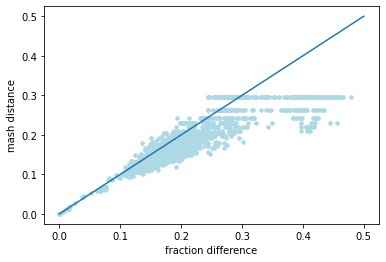

<Figure size 720x720 with 0 Axes>

In [214]:
plt.scatter(list_cog3, list_mash, c ="lightblue", s=10)
ident = [0.0, 0.5]
plt.plot(ident,ident)
plt.xlabel("fraction difference")
plt.ylabel("mash distance")
plt.figure(figsize=(10, 10))
plt.show()

When sequences become more divergent, Mash distance seems underestimate their difference. The reason may be the estimation of Jaccard similarity they used. 

In MASH, two randomly obtained sets of hashed k-mers are used to estimate the jaccard similarity. So, the number of their intersections must be discrete, which reduces the accuracy of distance. 